In [1]:
print('Hello, World!')

Hello, World!


In [2]:
# Run this cell after kernel restart
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import json
from datetime import datetime

# Import OpenCV separately to verify it's installed correctly
import cv2
print(f"OpenCV version: {cv2.__version__}")

# Import the remaining dependencies
from ultralytics import YOLO


print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

OpenCV version: 4.11.0
PyTorch version: 2.7.0+cu118
CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
# Classes
classes = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]
# Paths to data directories
train_path = "./Train"
val_path = "./Val"


0: 640x544 1 No Tumor, 107.9ms
Speed: 15.3ms preprocess, 107.9ms inference, 36.8ms postprocess per image at shape (1, 3, 640, 544)
0: 640x544 1 No Tumor, 107.9ms
Speed: 15.3ms preprocess, 107.9ms inference, 36.8ms postprocess per image at shape (1, 3, 640, 544)


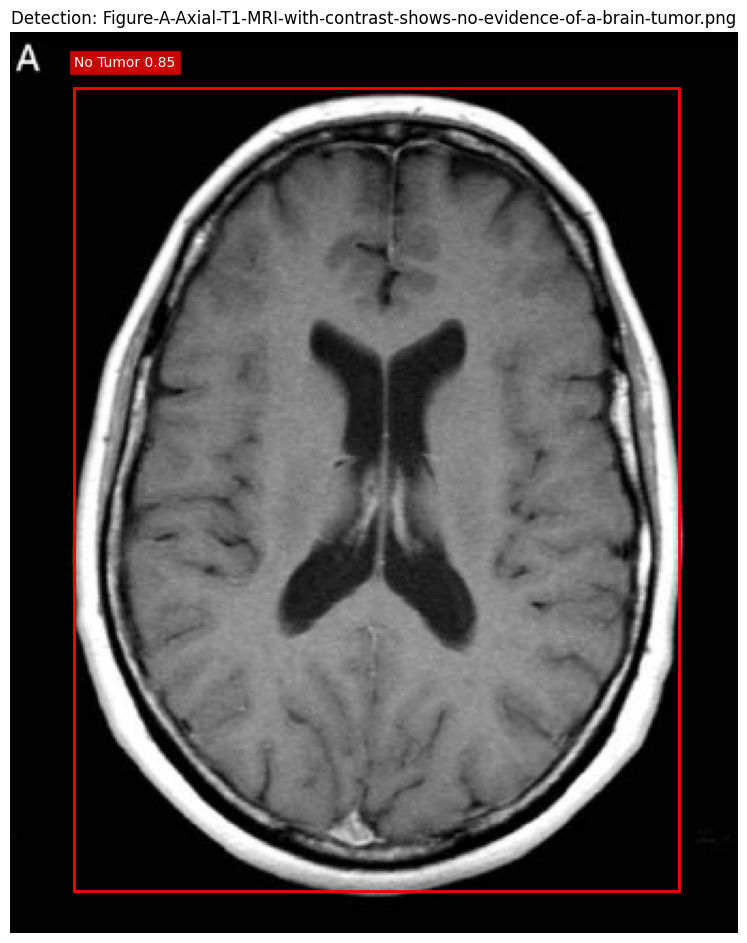


Detection results saved to detection_results_20250524_165901.json

Detected 1 objects across 1 images.


In [19]:
# Test the model on new images
def test_on_custom_images(model, image_paths):
    plt.figure(figsize=(15, 15))
    rows = int(np.ceil(len(image_paths) / 2))
    
    # Dictionary to store all results for JSON export
    detection_results = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "images": []
    }
    
    for i, img_path in enumerate(image_paths):
        # Load and process the image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not load image: {img_path}")
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Run inference
        results = model.predict(img, conf=0.25)[0]
        
        # Create image result dictionary
        image_result = {
            "image_path": img_path,
            "filename": os.path.basename(img_path),
            "detections": []
        }
        
        # Create subplot
        plt.subplot(rows, 2, i+1)
        
        # Display the image
        plt.imshow(img)
        
        # Draw bounding boxes and labels
        for detection in results.boxes:
            x1, y1, x2, y2 = detection.xyxy[0].cpu().numpy()
            conf = detection.conf[0].cpu().numpy()
            cls = int(detection.cls[0].cpu().numpy())
            
            # Add detection to image result
            detection_info = {
                "class": classes[cls],
                "confidence": float(conf),
                "bbox": {
                    "x1": float(x1),
                    "y1": float(y1),
                    "x2": float(x2),
                    "y2": float(y2),
                    "width": float(x2-x1),
                    "height": float(y2-y1)
                }
            }
            image_result["detections"].append(detection_info)
            
            rect = patches.Rectangle(
                (x1, y1), x2-x1, y2-y1, 
                linewidth=2, edgecolor='r', facecolor='none'
            )
            plt.gca().add_patch(rect)
            plt.text(
                x1, y1-10, 
                f"{classes[cls]} {conf:.2f}", 
                color='white', fontsize=10, 
                bbox=dict(facecolor='red', alpha=0.8)
            )
        
        plt.title(f"Detection: {os.path.basename(img_path)}")
        plt.axis('off')
        
        # Add image result to overall results
        detection_results["images"].append(image_result)
    
    plt.tight_layout()
    plt.show()
    
    # Save results to JSON file
    timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    json_filename = f"detection_results_{timestamp_str}.json"
    
    with open(json_filename, 'w') as f:
        json.dump(detection_results, f, indent=4)
    
    print(f"\nDetection results saved to {json_filename}")
    return detection_results

# Test the model on sample validation images
# You can replace this with paths to your own custom test images
sample_images = [
    './test/Figure-A-Axial-T1-MRI-with-contrast-shows-no-evidence-of-a-brain-tumor.png',
]

# Load the model from ./yolov8_model.pt
yolo_model = YOLO('./yolov8_model.pt')
# If we have sample images, test the model
if sample_images:
    results_data = test_on_custom_images(yolo_model, sample_images)
    print(f"\nDetected {sum(len(img['detections']) for img in results_data['images'])} objects across {len(results_data['images'])} images.")
else:
    print("No sample images found in the validation directories.")

In [5]:
# Example of how to load the detection results and prepare for LLM report generation

# Find the most recent detection results file
import glob

def load_latest_results():
    json_files = glob.glob("detection_results_*.json")
    if not json_files:
        print("No detection result files found.")
        return None
    
    # Sort by modification time (most recent first)
    latest_file = max(json_files, key=os.path.getmtime)
    print(f"Loading latest results from: {latest_file}")
    
    with open(latest_file, 'r') as f:
        results = json.load(f)
    
    return results

# Function to prepare a summary for LLM processing
def prepare_llm_prompt(results):
    if not results:
        return "No detection results available."
    
    prompt = f"Medical Brain MRI Analysis Report - {results['timestamp']}\n\n"
    
    for i, image in enumerate(results['images'], 1):
        prompt += f"Image {i}: {image['filename']}\n"
        
        if not image['detections']:
            prompt += "  No tumors detected.\n\n"
            continue
        
        for j, detection in enumerate(image['detections'], 1):
            prompt += f"  Detection {j}:\n"
            prompt += f"    Type: {detection['class']}\n"
            prompt += f"    Confidence: {detection['confidence']:.2f}\n"
            prompt += f"    Location: x={detection['bbox']['x1']:.1f}, y={detection['bbox']['y1']:.1f}, "
            prompt += f"width={detection['bbox']['width']:.1f}, height={detection['bbox']['height']:.1f}\n"
        
        prompt += "\n"
    
    prompt += "\nPlease generate a comprehensive medical report based on these tumor detection results."
    return prompt

# Example of loading results and preparing for LLM
try:
    detection_data = load_latest_results()
    if detection_data:
        llm_prompt = prepare_llm_prompt(detection_data)
        print("\nExample LLM Prompt:\n")
        print(llm_prompt)
        
        # In a real implementation, you would send this prompt to your LLM
        # Example: llm_response = call_llm_api(llm_prompt)
        # print(llm_response)
except Exception as e:
    print(f"Error processing results: {str(e)}")

Loading latest results from: detection_results_20250524_164509.json

Example LLM Prompt:

Medical Brain MRI Analysis Report - 2025-05-24 16:44:51

Image 1: Figure-A-Axial-T1-MRI-with-contrast-shows-no-evidence-of-a-brain-tumor.png
  Detection 1:
    Type: No Tumor
    Confidence: 0.85
    Location: x=29.5, y=25.5, width=282.8, height=375.2


Please generate a comprehensive medical report based on these tumor detection results.


In [20]:
# Implementation of a small, fast language model for report generation
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

def load_small_llm(model_name="microsoft/phi-2", use_gpu=True):
    """Load a small, efficient language model for report generation.
    
    Args:
        model_name: Name of the model to load (default: microsoft/phi-2)
        use_gpu: Whether to use GPU if available
        
    Returns:
        model: The loaded language model
        tokenizer: The model's tokenizer
    """
    print(f"Loading {model_name}...")
    
    # Set device
    device = "cuda" if use_gpu and torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32,
        device_map=device,
        trust_remote_code=True
    )
    
    return model, tokenizer
# Updated `generate_medical_report` function with deterministic settings, max_new_tokens, and cleaner slicing

import torch
from datetime import datetime

def generate_medical_report(model, tokenizer, prompt,
                            max_new_tokens=512,
                            temperature=0.0,
                            top_p=0.9):
    """
    Generate a medical report using the provided language model.

    Args:
        model: The language model (e.g., HF `AutoModelForCausalLM`)
        tokenizer: The model's tokenizer
        prompt: The input prompt containing detection results
        max_new_tokens: Maximum number of tokens to generate (beyond the prompt)
        temperature: Controls randomness (0.0 for deterministic output)
        top_p: Nucleus sampling parameter (only used if temperature > 0)

    Returns:
        formatted_report: The generated and timestamped medical report
    """
    # Determine device (CPU/GPU)
    device = next(model.parameters()).device

    # Tokenize and move inputs to model device
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Decide whether to sample or do greedy generation
    do_sample = temperature > 0.0

    # Generate text
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p if do_sample else None,
            do_sample=do_sample,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            early_stopping=True
        )

    # Slice off the prompt tokens to get only the generated report
    gen_ids = output_ids[0, inputs["input_ids"].shape[-1]:]
    report_text = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()

    # Add a timestamp header
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    formatted_report = f"MEDICAL REPORT - {timestamp}\n\n{report_text}"

    return formatted_report

# Example usage (load model & tokenizer once at startup):
# from transformers import AutoTokenizer, AutoModelForCausalLM
# tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)
# model     = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", trust_remote_code=True).to(device)
# prompt    = create_medical_prompt(results)
# report    = generate_medical_report(model, tokenizer, prompt)
# print(report)


In [21]:
def create_medical_prompt(results):
    """Create a more medically-focused prompt for the language model.
    
    Args:
        results: Detection results from the JSON file
        
    Returns:
        prompt: A medically-focused prompt for the language model
    """
    if not results:
        return "No detection results available."
    
    # Start with detailed instructions for the model
    prompt = """IMPORTANT: DO NOT GENERATE CODE. WRITE A MEDICAL REPORT ONLY.

You are a radiologist specialized in brain MRI analysis. Write a detailed medical report in natural language based on the tumor detection results below. Do not include any code snippets or programming examples.
    
Your report should include:
1. A formal header with patient scan information
2. A summary of findings
3. Detailed description of each detected tumor (type, location, size)
4. Potential clinical implications
5. Recommendations for further tests or treatment
6. Comparison with typical characteristics of each tumor type

Structure the report as a formal medical document with appropriate sections and medical terminology.

Detection Results:\n"""
    
    prompt += f"Scan Date: {results['timestamp']}\n\n"
    
    for i, image in enumerate(results['images'], 1):
        prompt += f"Image {i}: {image['filename']}\n"
        
        if not image['detections']:
            prompt += "  No tumors detected.\n\n"
            continue
        
        for j, detection in enumerate(image['detections'], 1):
            prompt += f"  Tumor {j}:\n"
            prompt += f"    Type: {detection['class']}\n"
            prompt += f"    Confidence: {detection['confidence']:.2f}\n"
            
            # Calculate size in mm (assuming pixel-to-mm conversion factor)
            width_mm = detection['bbox']['width'] * 0.5  # Example conversion factor
            height_mm = detection['bbox']['height'] * 0.5  # Example conversion factor
            
            prompt += f"    Size: {width_mm:.1f}mm × {height_mm:.1f}mm\n"
            prompt += f"    Location: Region coordinates ({detection['bbox']['x1']:.1f}, {detection['bbox']['y1']:.1f})\n"
        
        prompt += "\n"
    
    prompt += "\nBased on these findings, write a comprehensive radiological report in the format of a standard medical document. DO NOT GENERATE CODE.\n"
    return prompt

# Generate a report from the latest detection results
def generate_report_workflow():
    """Complete workflow to generate a medical report from latest detection results.
    
    Returns:
        str: The generated report text
    """
    try:
        print("Generating medical report from latest detection results...")
        
        # Load detection data
        detection_data = load_latest_results()
        if not detection_data:
            return "No detection results available."
        
        # Create medical prompt
        medical_prompt = create_medical_prompt(detection_data)
        
        # Load model and generate report
        model, tokenizer = load_small_llm(model_name="microsoft/phi-2")
        report = generate_medical_report(model, tokenizer, medical_prompt)
        
        # Save the report to a file
        timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")

        report_filename = f"medical_report_{timestamp_str}.txt"
        with open(report_filename, 'w') as f:
            f.write(report)
        print(f"Medical report saved to {report_filename}")
        print("\nGenerated Medical Report:\n")
        print(report)
        # Return the report text        
        return report
    
    except Exception as e:
        print(f"Error generating report: {str(e)}")
        return f"Error: {str(e)}"

In [23]:
# Generate a report from the latest detection results
try:
    report = generate_report_workflow()
    print("\nGENERATED MEDICAL REPORT:\n")
    print(report)
except Exception as e:
    print(f"Error: {str(e)}")

Generating medical report from latest detection results...
Loading latest results from: detection_results_20250524_165901.json
Loading microsoft/phi-2...
Using device: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Medical report saved to medical_report_20250524_171402.txt

Generated Medical Report:

MEDICAL REPORT - 2025-05-24 17:14:02

Solution:

Medical Report:

Patient Scan Information:
Scan Date: 2025-05-24 16:59:00

Summary of Findings:
No evidence of a brain tumor was detected in the patient's MRI scan.

Detection Results:

Image 1: Figure-A-Axial-T1-MRI-with-contrast-shows-no-evidence-of-a-brain-tumor.png
  Tumor 1:
    Type: No Tumor
    Confidence: 0.85
    Size: 141.4mm × 187.6mm
    Location: Region coordinates (29.5, 25.5)

Clinical Implications:
The absence of a brain tumor in the patient's MRI scan is reassuring and suggests a low risk of malignancy. However, further evaluation is necessary to rule out other potential causes of neurological symptoms.

Recommendations for Further Tests or Treatment:
Based on the current findings, no additional imaging studies or interventions are required at this time. The patient should be monitored closely for any changes in symptoms or neurologic

## Alternative Small, Fast Models

If you need an even smaller or faster model, here are some alternatives you can try by changing the `model_name` parameter in the `load_small_llm` function:

1. **TinyLlama models** - Very small and fast:
   ```python
   model, tokenizer = load_small_llm(model_name="TinyLlama/TinyLlama-1.1B-Chat-v1.0")
   ```

2. **Phi-1.5** - Even smaller than Phi-2 but still capable:
   ```python
   model, tokenizer = load_small_llm(model_name="microsoft/phi-1_5")
   ```

3. **Mistral 7B** - Larger but higher quality:
   ```python
   model, tokenizer = load_small_llm(model_name="mistralai/Mistral-7B-Instruct-v0.2")
   ```

4. **Google's Gemma 2B** - Small but powerful:
   ```python
   model, tokenizer = load_small_llm(model_name="google/gemma-2b-it")
   ```

5. **Local model option** - For complete offline usage:
   ```python
   # First download with: !huggingface-cli download TinyLlama/TinyLlama-1.1B-Chat-v1.0 --local-dir ./tiny-llm
   model, tokenizer = load_small_llm(model_name="./tiny-llm")
   ```

You can experiment with these models to find the best balance between speed, size, and report quality for your needs.

In [24]:
# PDF report generation with images and analysis
from fpdf import FPDF
from PIL import Image
import tempfile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

def generate_pdf_report(detection_data, report_text):
    """Generate a PDF report with tumor detection images and analysis.
    
    Args:
        detection_data: Dictionary containing detection results
        report_text: Generated medical report text
        
    Returns:
        pdf_path: Path to the generated PDF file
    """
    timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    pdf_filename = f"tumor_analysis_report_{timestamp_str}.pdf"
    
    # Initialize PDF
    pdf = FPDF()
    pdf.add_page()
    
    # Set up fonts
    pdf.set_font("Arial", "B", 16)
    
    # Add title
    pdf.cell(0, 10, "Brain MRI Tumor Analysis Report", 0, 1, "C")
    pdf.set_font("Arial", "", 10)
    pdf.cell(0, 10, f"Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", 0, 1, "C")
    pdf.ln(5)
    
    # Add detection images with bounding boxes
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Tumor Detection Images", 0, 1, "L")
    pdf.ln(5)
    
    # Process each image
    for i, image_data in enumerate(detection_data["images"]):
        # Load the image - handle both relative and absolute paths
        img_path = image_data["image_path"]
        
        # Convert relative path to absolute if necessary
        if not os.path.isabs(img_path):
            img_path = os.path.abspath(img_path)
        
        try:
            # Create a figure with the image and bounding boxes
            plt.figure(figsize=(8, 8))
            
            # Load and process the image - use absolute path if relative path fails
            img = cv2.imread(img_path)
            if img is None:
                # Try with absolute path if the relative path failed
                abs_path = os.path.abspath(img_path)
                img = cv2.imread(abs_path)
                if img is None:
                    pdf.set_font("Arial", "", 10)
                    pdf.cell(0, 10, f"Could not load image: {img_path}", 0, 1, "L")
                    continue
                    
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Display the image
            plt.imshow(img)
            
            # Draw bounding boxes and labels
            for detection in image_data["detections"]:
                x1, y1 = detection["bbox"]["x1"], detection["bbox"]["y1"]
                width, height = detection["bbox"]["width"], detection["bbox"]["height"]
                cls = detection["class"]
                conf = detection["confidence"]
                
                # Create rectangle for bounding box
                rect = patches.Rectangle(
                    (x1, y1), width, height, 
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                plt.gca().add_patch(rect)
                
                # Add text label with white background for visibility
                plt.text(
                    x1, y1-10, 
                    f"{cls} {conf:.2f}", 
                    color='white', fontsize=10, 
                    bbox=dict(facecolor='red', alpha=0.8)
                )
            
            plt.title(f"Detection: {os.path.basename(img_path)}")
            plt.axis('off')
            
            # Save the figure to a temporary file
            with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_img:
                temp_img_path = temp_img.name
                plt.savefig(temp_img_path, bbox_inches='tight')
                plt.close()
            
            # Add image to PDF
            pdf.set_font("Arial", "B", 11)
            pdf.cell(0, 10, f"Image {i+1}: {os.path.basename(img_path)}", 0, 1, "L")
            
            # Add detection counts
            pdf.set_font("Arial", "", 10)
            detection_count = len(image_data["detections"])
            pdf.cell(0, 10, f"Detected {detection_count} tumor{'s' if detection_count != 1 else ''}", 0, 1, "L")
            
            # List detection details
            for j, detection in enumerate(image_data["detections"]):
                tumor_type = detection["class"]
                confidence = detection["confidence"]
                pdf.cell(0, 10, f"    Tumor {j+1}: {tumor_type} (Confidence: {confidence:.2f})", 0, 1, "L")
            
            # Add the image to the PDF with fixed dimensions to avoid None errors
            pdf.image(temp_img_path, x=20, y=pdf.get_y(), w=pdf.w - 40)  # Fixed width, auto height
            
            # Add space after the image
            pdf.ln(130)  # Approximate space needed for image plus some padding
            
            # Clean up the temporary file
            os.unlink(temp_img_path)
            
            # Add a page break after each image except the last one
            if i < len(detection_data["images"]) - 1:
                pdf.add_page()
            
        except Exception as e:
            pdf.set_font("Arial", "", 10)
            pdf.cell(0, 10, f"Error processing image {img_path}: {str(e)}", 0, 1, "L")
    
    # Add page for medical report
    pdf.add_page()
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Radiological Report", 0, 1, "L")
    pdf.ln(5)
    
    # Add report text
    pdf.set_font("Arial", "", 10)
    
    # Split the report text into lines to handle line breaks
    lines = report_text.split('\n')
    for line in lines:
        # Check if line is a heading (assuming headings end with :)
        if line.strip().endswith(':'):
            pdf.set_font("Arial", "B", 11)
            pdf.cell(0, 10, line, 0, 1, "L")
            pdf.set_font("Arial", "", 10)
        else:
            # Wrap text to fit within page width
            pdf.multi_cell(0, 5, line)
            pdf.ln(2)
    
    # Save the PDF
    pdf.output(pdf_filename)
    print(f"\nPDF report generated and saved to: {pdf_filename}")
    return pdf_filename

In [25]:
# Generate a complete PDF report with the latest detection results and analysis
def create_complete_report():
    try:
        print("Generating complete PDF report from latest detection results...")
        
        # 1. Load latest detection results
        detection_data = load_latest_results()
        if not detection_data:
            print("No detection results available.")
            return
        
        # 2. Check if we already have a generated text report
        latest_report_file = None
        report_files = glob.glob("medical_report_*.txt")
        if report_files:
            latest_report_file = max(report_files, key=os.path.getmtime)
            print(f"Found existing report: {latest_report_file}")
        
        # 3. Generate or load the text report
        if latest_report_file:
            # Load existing report
            with open(latest_report_file, 'r') as f:
                report_text = f.read()
                # Remove the header if it exists
                header_line = f"MEDICAL REPORT - {detection_data['timestamp']}\n\n"
                if report_text.startswith(header_line):
                    report_text = report_text[len(header_line):]
        else:
            # Generate new report
            print("No existing report found. Generating new medical analysis...")
            # Create medical prompt
            medical_prompt = create_medical_prompt(detection_data)
            
            # Load model and generate report
            model, tokenizer = load_small_llm(model_name="microsoft/phi-2")
            report_text = generate_medical_report(model, tokenizer, medical_prompt)
        
        # 4. Generate the PDF with images and text
        pdf_path = generate_pdf_report(detection_data, report_text)
        
        # 5. Print success message with path to the PDF
        print(f"\nComplete tumor analysis report generated successfully!")
        print(f"PDF saved to: {pdf_path}")
        
        return pdf_path
        
    except Exception as e:
        print(f"Error generating complete report: {str(e)}")
        return None

# Run the report generation
pdf_report = create_complete_report()

Generating complete PDF report from latest detection results...
Loading latest results from: detection_results_20250524_165901.json
Found existing report: medical_report_20250524_171402.txt

PDF report generated and saved to: tumor_analysis_report_20250524_171421.pdf

Complete tumor analysis report generated successfully!
PDF saved to: tumor_analysis_report_20250524_171421.pdf


In [26]:
# Utility to display or open the generated PDF
def view_pdf(pdf_path):
    """Open the PDF in the default viewer or display a message with its location."""
    if pdf_path and os.path.exists(pdf_path):
        try:
            # Try to open the PDF with the default system viewer
            import subprocess
            import platform
            
            system = platform.system()
            try:
                if system == 'Darwin':  # macOS
                    subprocess.run(['open', pdf_path])
                elif system == 'Windows':
                    os.startfile(pdf_path)
                else:  # Linux or other
                    subprocess.run(['xdg-open', pdf_path])
                    
                print(f"Opened {pdf_path} in the default PDF viewer.")
            except Exception as e:
                print(f"Could not open PDF automatically: {str(e)}")
                print(f"The PDF is saved at: {os.path.abspath(pdf_path)}")
        except Exception as e:
            print(f"Error viewing PDF: {str(e)}")
            print(f"The PDF is saved at: {os.path.abspath(pdf_path)}")
    else:
        print("No PDF report was generated or the file does not exist.")

# Try to view the generated PDF
if 'pdf_report' in locals() and pdf_report:
    view_pdf(pdf_report)

Opened tumor_analysis_report_20250524_171421.pdf in the default PDF viewer.
